In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

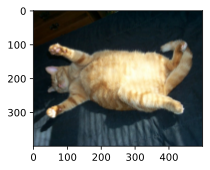

In [2]:
d2l.set_figsize()
img = d2l.Image.open('../data/img/cat1.jpg')
d2l.plt.imshow(img)

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

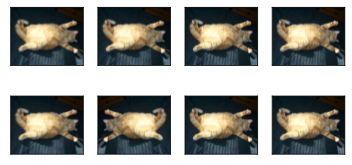

In [4]:
# 水平翻转
apply(img, torchvision.transforms.RandomHorizontalFlip())

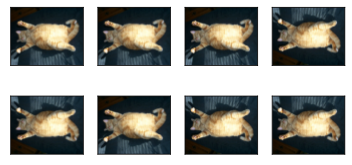

In [5]:
# 上下翻转
apply(img, torchvision.transforms.RandomVerticalFlip())

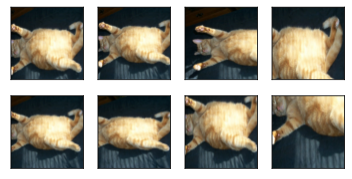

In [6]:
# 随机剪裁
shape_aug = torchvision.transforms.RandomResizedCrop(size=(200,200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

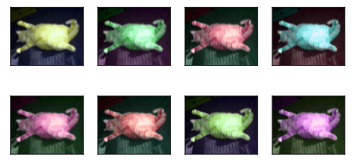

In [7]:
# 改变颜色
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5))

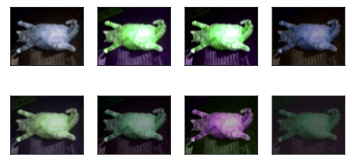

In [8]:
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

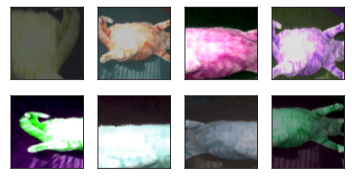

In [9]:
# 结合多种增广方法
augs = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

In [10]:
# 下载 CIFAR10 数据
all_images = torchvision.datasets.CIFAR10(train=True, root='../data', download=True)

Files already downloaded and verified


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

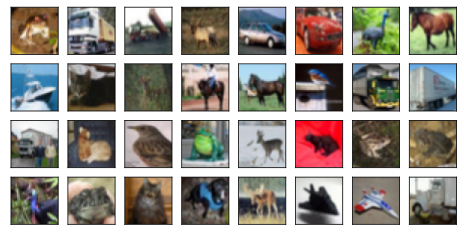

In [11]:
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=1)

In [12]:
len(all_images)

50000

In [13]:
train_augs = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()])
test_augs = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

In [14]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", 
                                           train=is_train, transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                             shuffle=is_train,
                                             num_workers=d2l.get_dataloader_workers())
    return dataloader

In [15]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """小批量训练"""
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [16]:
#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                           legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, 
                             (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [17]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

In [18]:
# 线性层和卷积层使用这个初始化
def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)
        
net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 20, devices)

loss 0.056, train acc 0.981, test acc 0.858
1384.9 examples/sec on [device(type='cuda', index=0)]


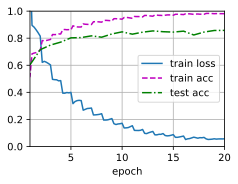

In [19]:
train_with_data_aug(train_augs, test_augs, net)

In [20]:
# batchsize=256, epoch=10, lr=0.001 loss 0.166, train acc 0.943, test acc 0.836
# batchsize=256, epoch=20, lr=0.001 loss 0.053, train acc 0.982, test acc 0.854 executed in 16m 3s
# batchsize=256, epoch=10, lr=0.01 loss 0.482, train acc 0.833, test acc 0.747
# batchsize=256, epoch=20, lr=0.01 loss 0.143, train acc 0.949, test acc 0.760
# batchsize=256, epoch=20, lr=0.001 loss 0.056, train acc 0.981, test acc 0.858 再加 20 epoch loss 0.029, train acc 0.990, test acc 0.858